DL network architecture for LeNet-5

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F



class LeNet5(nn.Module):
    def __init__(self, num_of_classes):
        # Initialize the parent class (nn.Module)
        super(LeNet5, self).__init__()

        # Layer 1: Convolutional + Pooling
        ''' we are using three channels as input (instead of 1) for some experiments that will be done later '''
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=6, kernel_size=5, stride=1, padding=2)  # 28x28 -> 28x28
        self.pool1 = nn.AvgPool2d(kernel_size=2, stride=2)  # 28x28 -> 14x14

        # Layer 2: Convolutional + Pooling
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5, stride=1)  # 14x14 -> 10x10
        self.pool2 = nn.AvgPool2d(kernel_size=2, stride=2)  # 10x10 -> 5x5

        # Layer 3: Fully Connected
        self.fc1 = nn.Linear(in_features=16*5*5, out_features=120)

        # Layer 4: Fully Connected
        self.fc2 = nn.Linear(in_features=120, out_features=84)

        # Layer 5: Output Layer
        self.fc3 = nn.Linear(in_features=84, out_features=num_of_classes)

    def forward(self, x):
        # Layer 1: Conv -> Pool -> Activation
        x = F.relu(self.pool1(self.conv1(x)))

        # Layer 2: Conv -> Pool -> Activation
        x = F.relu(self.pool2(self.conv2(x)))

        # Flatten the output from the convolutional layers
        x = x.view(-1, 16 * 5 * 5)

        # Layer 3: Fully Connected + Activation
        x = F.relu(self.fc1(x))

        # Layer 4: Fully Connected + Activation
        x = F.relu(self.fc2(x))

        # Layer 5: Fully Connected (Output)
        x = self.fc3(x)

        return x

# Creating a model object/instance
model = LeNet5(num_of_classes=10)
print(model)

LeNet5(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (pool1): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (pool2): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)


Load the data from pytorch datasets and then split into training, validation, and testing.

In [2]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt
import torchvision
import numpy as np

transform = transforms.Compose([
    transforms.Resize((28, 28)),
    transforms.Grayscale(num_output_channels=3),  # Convert grayscale to RGB by repeating channels
    transforms.ToTensor(),
    transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))
])
'''  Standard code from https://pytorch.org/vision/stable/datasets.html'''
# Load dataset
dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

# Split into training and validation sets
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# Create DataLoaders with a certain batch size
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:00<00:00, 32744205.97it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 1069555.30it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:00<00:00, 9145185.94it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 3526569.56it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



Visualize a few images from the batch and their labels

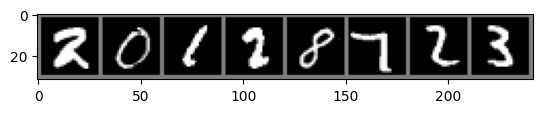

Labels: [2 0 1 2 8 7 2 3]


In [3]:
# Function to unnormalize and show images
def imshow(img):
    img = img / 2 + 0.5  # Unnormalize
    npimg = img.numpy()
    # Important when it is a Color (RGB) Image
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# Get a batch of training data
dataiter = iter(train_loader)
''' next(dataiter): Fetches the next batch from the train_loader'''
images, labels = next(dataiter)  # Use the built-in next() function


# Show images
imshow(torchvision.utils.make_grid(images[:8]))  # Show the first 8 images
print('Labels:', labels[:8].numpy())  # Print the corresponding labels

Define the device and optimizer function

In [4]:
import torch.optim as optim

'''  Decide if the calculations are perfomed by GPU or CPU  '''
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
'''.to(device): moves tensors and models to the specified device (either GPU or CPU).
This ensures that all computations happen on the same device, avoiding errors or inefficiencies.'''
model = model.to(device)
# Cross Entropy Loss for multi-class classification
criterion = nn.CrossEntropyLoss()
# Optimizer SGD or ADAM with learning rate
optimizer = optim.Adam(model.parameters(), lr=0.001)

Training and Validation both loss and accuracy

In [5]:

# Initialize lists to store training and validation metrics
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

# number of epochs
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        ''' torch.max(outputs, 1): The torch.max() function returns the maximum
        value of all elements in the tensor along a specified dimension.
         (_) is used for variables that we don't need to use   '''
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    train_loss = running_loss / len(train_loader)
    # append the list
    train_losses.append(train_loss)
    train_accuracy = 100 * correct / total
    # append the list
    train_accuracies.append(train_accuracy)

    # .eval indicates that the model is used for prediction.
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    val_loss /= len(val_loader)
    val_losses.append(val_loss)
    val_accuracy = 100 * correct / total
    val_accuracies.append(val_accuracy)

    print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%, Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%')


Epoch 1/10, Train Loss: 0.3259, Train Accuracy: 89.79%, Val Loss: 0.1279, Val Accuracy: 96.20%
Epoch 2/10, Train Loss: 0.0994, Train Accuracy: 96.98%, Val Loss: 0.0837, Val Accuracy: 97.50%
Epoch 3/10, Train Loss: 0.0711, Train Accuracy: 97.81%, Val Loss: 0.0678, Val Accuracy: 98.03%
Epoch 4/10, Train Loss: 0.0585, Train Accuracy: 98.20%, Val Loss: 0.0642, Val Accuracy: 98.07%
Epoch 5/10, Train Loss: 0.0485, Train Accuracy: 98.41%, Val Loss: 0.0575, Val Accuracy: 98.33%
Epoch 6/10, Train Loss: 0.0411, Train Accuracy: 98.71%, Val Loss: 0.0636, Val Accuracy: 98.21%
Epoch 7/10, Train Loss: 0.0355, Train Accuracy: 98.87%, Val Loss: 0.0526, Val Accuracy: 98.25%
Epoch 8/10, Train Loss: 0.0319, Train Accuracy: 98.96%, Val Loss: 0.0544, Val Accuracy: 98.50%
Epoch 9/10, Train Loss: 0.0251, Train Accuracy: 99.20%, Val Loss: 0.0583, Val Accuracy: 98.31%
Epoch 10/10, Train Loss: 0.0246, Train Accuracy: 99.16%, Val Loss: 0.0605, Val Accuracy: 98.37%


Plot the Training and Validation performances over epochs

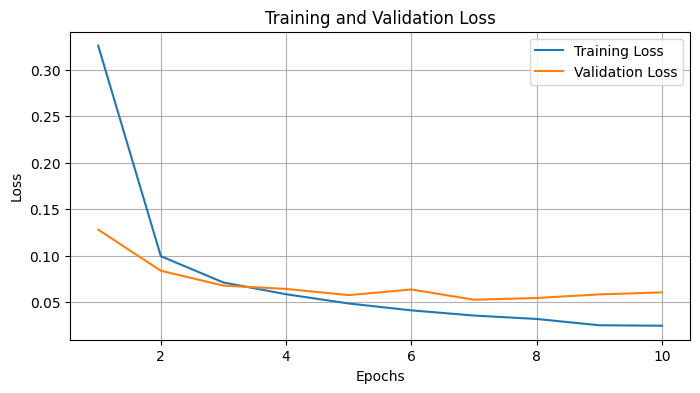

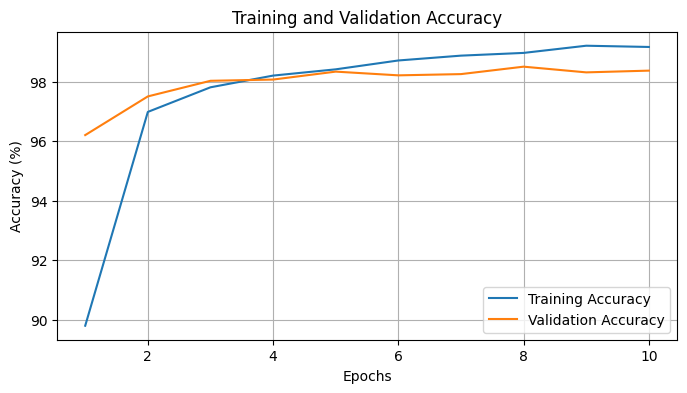

In [6]:

# Plot training and validation loss
plt.figure(figsize=(8,4))
plt.plot(range(1, num_epochs+1), train_losses, label='Training Loss')
plt.plot(range(1, num_epochs+1), val_losses, label='Validation Loss')
plt.grid()
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

# Plot training and validation accuracy
plt.figure(figsize=(8,4))
plt.plot(range(1, num_epochs+1), train_accuracies, label='Training Accuracy')
plt.plot(range(1, num_epochs+1), val_accuracies, label='Validation Accuracy')
plt.grid()
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

Test the perfroance of the trained model for test data

In [ ]:
# Testing
model.eval()
test_loss = 0.0
correct = 0
total = 0
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        test_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
test_loss /= len(test_loader)
test_accuracy = 100 * correct / total

print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%')

Test Loss: 0.0560, Test Accuracy: 98.46%


Visualize the results for a Test batch

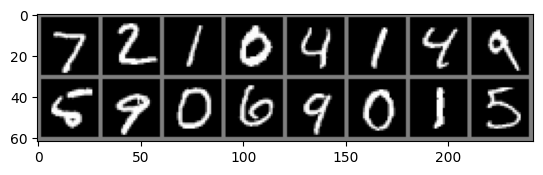

Ground Truth:     7 2 1 0 4 1 4 9 5 9 0 6 9 0 1 5
Predicted Val:    7 2 1 0 4 1 4 9 5 9 0 6 9 0 1 5


In [ ]:
# Get a batch of test data
no_of_samples = 16
dataiter = iter(test_loader)
images, labels = next(dataiter)  # Use the built-in next() function

# Show images
imshow(torchvision.utils.make_grid(images[:no_of_samples]))
print('Ground Truth:    ', ' '.join(f'{labels[j]}' for j in range(no_of_samples)))

images = images.to(device)
outputs = model(images)
_, predicted = torch.max(outputs, 1)

print('Predicted Val:   ', ' '.join(f'{predicted[j].item()}' for j in range(no_of_samples)))
